In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import os
import json

import pandas as pd
import seaborn as sns
import graphviz
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict

# import data.drawings.make_tasks as drawing_tasks
from src.analysis_utilities import SynthesisExperimentAnalyzer
from src.config_builder import ExperimentType
from src.models.library_namer import LibraryNamerPrompt
from src.models.laps_grammar import LAPSGrammar
from src.experiment_iterator import ExperimentState

from run_experiment import *
from dreamcoder.program import Program, prettyProgram, PrettyVisitor

In [63]:
# re2
# DOMAIN = "REGEX"
# RUN_PATH = "experiments_iterative/outputs/runs_re2/domains/re2/gpt_solver_stitch_namer_search/seed_111/gpt_solver_stitch_namer_search_96"
# RUN_PATH = "experiments_iterative/outputs/runs_re2/domains/re2/gpt_solver_stitch_namer_search/seed_222/gpt_solver_stitch_namer_search_96"
# RUN_PATH = "experiments_iterative/outputs/runs_re2/domains/re2/gpt_solver_stitch_namer_search/seed_333/gpt_solver_stitch_namer_search_96"
# ITERATION = 15

# RUN_PATH = "experiments_iterative/outputs/runs_re2/domains/re2/gpt_solver_stitch_namer/seed_111/gpt_solver_stitch_namer_96"
# ITERATION = 9

# clevr
DOMAIN = "CLEVR"
# RUN_PATH = "experiments_iterative/outputs/runs_clevr/domains/clevr/gpt_solver_stitch_namer/seed_111/gpt_solver_stitch_namer_96"
RUN_PATH = "experiments_iterative/outputs/runs_clevr/domains/clevr/gpt_solver_stitch_namer/seed_222/gpt_solver_stitch_namer_96"
# RUN_PATH = "experiments_iterative/outputs/runs_clevr/domains/clevr/gpt_solver_stitch_namer/seed_333/gpt_solver_stitch_namer_96"
ITERATION = 9

# logo
# DOMAIN = "LOGO"
# RUN_PATH = "experiments_iterative/outputs/runs_logo/domains/logo/gpt_solver_stitch_namer/seed_111/gpt_solver_stitch_namer_96"
# # RUN_PATH = "experiments_iterative/outputs/runs_logo/domains/logo/gpt_solver_stitch_namer/seed_222/gpt_solver_stitch_namer_96"
# # RUN_PATH = "experiments_iterative/outputs/runs_logo/domains/logo/gpt_solver_stitch_namer/seed_333/gpt_solver_stitch_namer_96"
# ITERATION = 9

# DOMAIN = "CLEVR"
# RUN_PATH = "lilo_arxiv_v1/outputs/runs_multi/domains/clevr/gpt_solver_stitch_namer/seed_222/gpt_solver_stitch_namer_96"
# ITERATION = 9

FIGURES_DIR = os.path.join("figures", "library_analysis")
os.makedirs(FIGURES_DIR, exist_ok=True)

CONFIG_PATH = os.path.join(RUN_PATH, "config.json")
LIBRARY_NAMING_RESULTS_PATH = os.path.join(RUN_PATH, str(ITERATION - 1), "train", "gpt_library_namer_results.json")

In [64]:
with open(LIBRARY_NAMING_RESULTS_PATH, "r") as f:
    data = json.load(f)
    
with open(CONFIG_PATH) as f:
    config_json = json.load(f)
    config_json["metadata"]["init_grammar_from_checkpoint"] = True
    config_json["metadata"]["resume_checkpoint_directory"] = None
    config_json["metadata"]["curr_iteration"] = ITERATION
    experiment_state = ExperimentState(config_json)

grammar = experiment_state.models["grammar"]

Loaded 8 CLEVR question classes: dict_keys(['2_transform', '1_one_hop', '2_remove', '1_same_relate_restricted', '2_localization', '1_single_or', '1_compare_integer', '1_zero_hop'])
Loading dataset 1_compare_integer: train: found 6 tasks.
Loading dataset 1_compare_integer: val: found 4 tasks.
Loading dataset 1_one_hop: train: found 30 tasks.
Loading dataset 1_one_hop: val: found 10 tasks.
Loading dataset 1_single_or: train: found 25 tasks.
Loading dataset 1_single_or: val: found 10 tasks.
Loading dataset 1_zero_hop: train: found 30 tasks.
Loading dataset 1_zero_hop: val: found 30 tasks.
Loading dataset 2_localization: train: found 58 tasks.
Loading dataset 2_localization: val: found 30 tasks.
Loading dataset 2_remove: train: found 23 tasks.
Loading dataset 2_remove: val: found 9 tasks.
Loading dataset 2_transform: train: found 22 tasks.
Loading dataset 2_transform: val: found 10 tasks.
Loaded a total of 194 training tasks and 103 testing tasks for curriculum datasets: [] and main datase

/home/ubuntu/lilo/src/experiment_iterator.py:326: RuntimeWarning: All-NaN axis encountered
  none_to_nan(json_frontier["best_search_time"]),


In [65]:
for fn_body, fn_data in data["abstractions"].items():
    print(fn_body)
    grammar.set_function_name(fn_body, name_class="human_readable", name=fn_data["readable_name"])

#(lambda (lambda (clevr_fold $0 $0 (lambda (lambda (clevr_map (lambda (clevr_if (clevr_eq_size (clevr_query_size $0) $4) $0 $2)) $0))))))
#(lambda (lambda (clevr_fold $0 clevr_empty (lambda (lambda (clevr_if (clevr_eq_color (clevr_query_color $1) $3) (clevr_add $1 $0) $0))))))
#(lambda (lambda (clevr_fold $0 clevr_empty (lambda (lambda (clevr_if (clevr_eq_material (clevr_query_material $1) $3) (clevr_add $1 $0) $0))))))
#(lambda (lambda (clevr_fold $0 clevr_empty (lambda (lambda (clevr_if (clevr_eq_shape (clevr_query_shape $1) $3) (clevr_add $1 $0) $0))))))
#(lambda (lambda (clevr_fold $0 $0 (lambda (lambda (clevr_map (lambda (clevr_if (clevr_eq_color (clevr_query_color $0) $4) $0 $2)) $0))))))
#(lambda (#(lambda (lambda (clevr_fold $0 $0 (lambda (lambda (clevr_map (lambda (clevr_if (clevr_eq_size (clevr_query_size $0) $4) $0 $2)) $0)))))) clevr_small $0))
#(lambda (#(lambda (lambda (clevr_fold $0 clevr_empty (lambda (lambda (clevr_if (clevr_eq_material (clevr_query_material $1) $3) (c

# Print out the library as document

In [66]:
for fn_body, fn_data in data["abstractions"].items():
    fn_body_readable = grammar.show_program(fn_body[1:], name_classes=["human_readable"], debug=True)
    
    print(f"({fn_data['anonymous_name']}) {fn_data['readable_name']} :: {Program.parse(fn_body[1:]).infer()}")
    print(fn_body_readable)
    print("{- " + fn_data["description"] + " -}")
    print()
    
    print("{- " + "Example usages" + " -}")
    for usage_data in fn_data['usage_examples'][:3]:
        print("--" + usage_data['language'])
        print(grammar.show_program(usage_data['program'], name_classes=["human_readable"], debug=True))
        
    print()

(fn_54) filter_by_size :: tclevrsize -> list(tclevrobject) -> list(tclevrobject)
(lambda (lambda (clevr_fold $0 $0 (lambda (lambda (clevr_map (lambda (clevr_if (clevr_eq_size (clevr_query_size $0) $4) $0 $2)) $0))))))
{- Returns a list of objects in the input list that have the specified size. -}

{- Example usages -}

(fn_55) filter_by_color :: tclevrcolor -> list(tclevrobject) -> list(tclevrobject)
(lambda (lambda (clevr_fold $0 clevr_empty (lambda (lambda (clevr_if (clevr_eq_color (clevr_query_color $1) $3) (clevr_add $1 $0) $0))))))
{- Returns a list of objects in the input list that have the specified color. -}

{- Example usages -}
--what color is the small metal thing behind the small purple metal thing
(lambda (clevr_query_color (clevr_car (filter_objects_by_material (filter_objects_by_small_size (clevr_relate (clevr_car (filter_by_color clevr_purple (filter_objects_by_material (filter_objects_by_small_size $0)))) clevr_behind $0))))))
--what is the size of the gray thing
(lamb

# Library graph

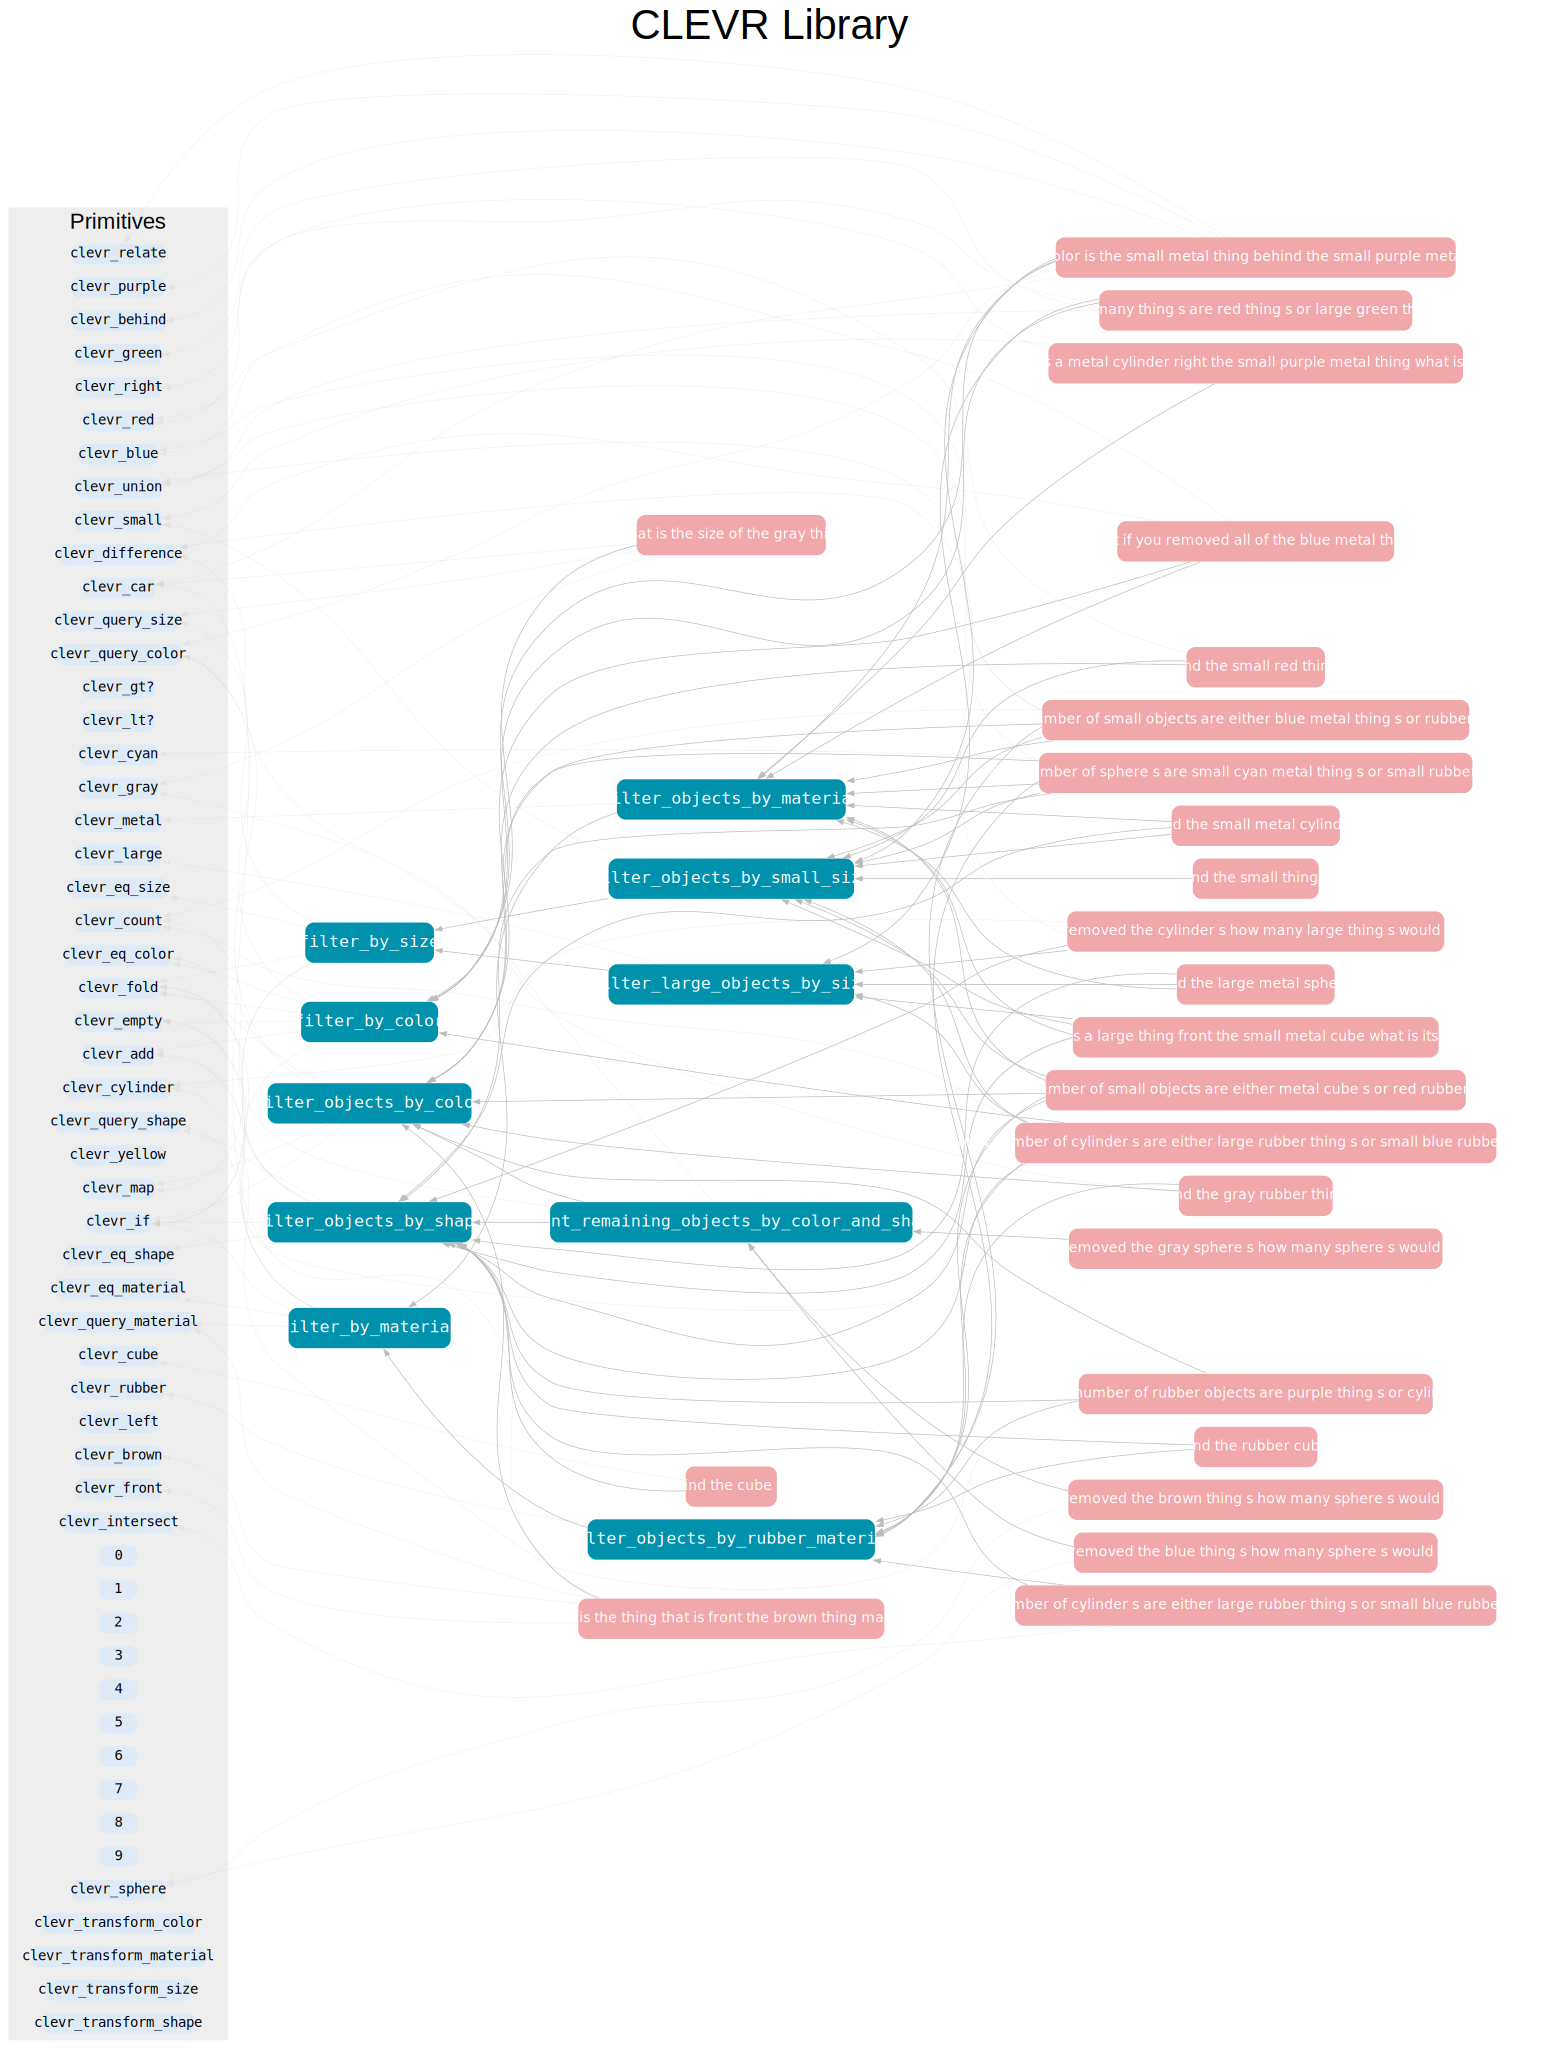

'library_CLEVR.pdf'

In [67]:
ASPECT = 1.2

# Nodes
HEX_ABSTRACTION = '#0091AD'
HEX_PRIMITIVE = '#DEEBF7'
HEX_LANGUAGE = '#F0A8AA'

# Background of Base DSL
HEX_PRIMITIVE_BACKGROUND = "#EEEEEE"

# Lines
HEX_LINE_LIGHT = '#CCCCCC40'
HEX_LINE_HEAVY = '#BBBBBB'

# Font sizes
FONT_SIZE_ABSTRACTION = 24
FONT_SIZE_PRIMITIVE = 20
FONT_SIZE_LANGUAGE = 20
FONT_SIZE_TITLE = 60
FONT_SIZE_HEADING = 32

# Set of all abstractions
abstractions_readable = [grammar.show_program(p, name_classes=["human_readable"], debug=True) for p in grammar.primitives if p.isInvented]

# Randomly sample edges to include
SEED = 42
rng = np.random.default_rng(SEED)

# Main graph
graph = graphviz.Digraph(graph_attr={'rankdir': 'RL', 'ratio': str(ASPECT)}, strict=True)

# Construct all nodes
for p in grammar.primitives:
    fn_name_readable = grammar.show_program(p, name_classes=["human_readable"], debug=True)
    
    if p.isInvented:
        # with graph.subgraph(name="cluster_abstractions", graph_attr={'rankdir': 'TB'}) as g_abstractions:
        graph.node(
            fn_name_readable, 
            label=fn_name_readable, 
            shape='box', 
            style='rounded, filled, bold, setlinewidth(0)', 
            fillcolor=HEX_ABSTRACTION,
            fontname='Inconsolata', 
            fontsize=str(FONT_SIZE_ABSTRACTION),
            fontcolor="white",
            height="0.8in"
        )
    else:
        # Primitives cluster
        with graph.subgraph(name="cluster_primitives", graph_attr={'rankdir': 'TB'}) as g_primitives:
            g_primitives.node(
                fn_name_readable, 
                label=fn_name_readable, 
                shape='box', 
                style='rounded, filled, setlinewidth(0)', 
                fillcolor=HEX_PRIMITIVE, 
                fontname='Inconsolata', 
                fontsize=str(FONT_SIZE_PRIMITIVE), 
                height="0.2in",
            )

# Connect edges
token_to_hit_count = defaultdict(int)

for p in grammar.primitives:
    if p.isInvented:

        fn_name_readable = grammar.show_program(p, name_classes=["human_readable"], debug=True)
        
        tokens = Program.parse(str(p)[1:]).left_order_tokens()
        for t in tokens:
            token_readable = grammar.show_program(t, name_classes=["human_readable"], debug=True)
            
            # Preserves ordering of primitives but makes layout weird
            # graph.edge(fn_name_readable, token_readable, color="#DDDDDD", constraint="false")
            
            if token_readable in abstractions_readable:
                graph.edge(fn_name_readable, token_readable, color=HEX_LINE_HEAVY)
            else:
                graph.edge(fn_name_readable, token_readable, color=HEX_LINE_LIGHT)
            
            # Node has inbound arrow
            token_to_hit_count[token_readable] += 1
    
with graph.subgraph(name="cluster_primitives") as g_primitives:
    g_primitives.attr(label='Primitives', fontname="helvetica", fontsize=str(FONT_SIZE_HEADING), style="bold")
    g_primitives.attr(bgcolor=HEX_PRIMITIVE_BACKGROUND, color=HEX_PRIMITIVE_BACKGROUND)
    
    
# Add example usages
for fn_body, fn_data in data["abstractions"].items():
    fn_body_readable = grammar.show_program(fn_body[1:], name_classes=["human_readable"], debug=True)
    
    for usage_data in fn_data['usage_examples'][:3]:
        language = usage_data['language']
        p_base_dsl = grammar.show_program(usage_data['program'], debug=True)
        
        p_readable = grammar.show_program(p_base_dsl, name_classes=["human_readable"], debug=True)
        
        graph.node(
            str(p_base_dsl), 
            label=language, 
            shape='box', 
            style='rounded, filled, bold, setlinewidth(0)', 
            fillcolor=HEX_LANGUAGE, 
            fontname='times italic',
            fontsize=str(FONT_SIZE_LANGUAGE),
            fontcolor="white",
            height="0.8in"
        )
        
        tokens = Program.parse(p_base_dsl).left_order_tokens()
        
        for t in tokens:
            token_readable = grammar.show_program(t, name_classes=["human_readable"], debug=True)
            if token_readable in abstractions_readable:
                graph.edge(str(p_base_dsl), token_readable, color=HEX_LINE_HEAVY)
                
            else:
                hit_count = token_to_hit_count[token_readable]
                if rng.binomial(n=1, p=(1 / (1 + hit_count))):
                    graph.edge(str(p_base_dsl), token_readable, color=HEX_LINE_LIGHT)
                    token_to_hit_count[token_readable] += 1
    
    
graph.attr(label=f"{DOMAIN} Library", fontname="helvetica", fontsize=str(FONT_SIZE_TITLE), style="bold", labelloc="t")

    
display(graph)

graph.render(f"library_{DOMAIN}", format="pdf")
# graph.render(f"library_{DOMAIN}", format="png")

# Abstraction arguments

In [36]:
for fn_body, fn_data in data["abstractions"].items():
    
    programs = sorted([grammar.show_program(example["program"], input_name_class=["human_readable"]) for example in fn_data["usage_examples"]])
    break
    
p = Program.parse(programs[0])
p

(lambda (#(lambda (lambda (lambda (logo_forLoop $1 (lambda (lambda (logo_FWRT $2 (logo_DIVA logo_UA $3) $0))) $2)))) $0 1 logo_UL))

In [37]:
data["abstractions"]

{'#(lambda (lambda (lambda (logo_forLoop $1 (lambda (lambda (logo_FWRT $2 (logo_DIVA logo_UA $3) $0))) $2))))': {'anonymous_name': 'fn_27',
  'readable_name': 'turtle_loop_move_rotate',
  'description': 'Repeatedly move the turtle forward and rotate it by a specified angle, creating a loop of a specific number of sides with a given line length.',
  'usage_examples': [{'task_name': 'a small square',
    'program': '(lambda (fn_27 $0 4 logo_unit_line))',
    'language': 'a small square'},
   {'task_name': 'a small 7 gon',
    'program': '(lambda (fn_27 $0 7 logo_unit_line))',
    'language': 'a small 7 gon'},
   {'task_name': 'a short line',
    'program': '(lambda (fn_27 $0 1 logo_unit_line))',
    'language': 'a short line'},
   {'task_name': 'a small 8 gon',
    'program': '(lambda (fn_27 $0 8 logo_unit_line))',
    'language': 'a small 8 gon'},
   {'task_name': 'a small 9 gon',
    'program': '(lambda (fn_27 $0 9 logo_unit_line))',
    'language': 'a small 9 gon'},
   {'task_name': '

In [38]:
abstraction = Program.parse(list(data["abstractions"].keys())[0])
abstraction

#(lambda (lambda (lambda (logo_forLoop $1 (lambda (lambda (logo_FWRT $2 (logo_DIVA logo_UA $3) $0))) $2))))

In [39]:
# Heuristic to extract args
def get_arguments_for_abstraction_in_program(program, abstraction):
    program = str(program)
    abstraction = str(abstraction)
    
    if program.count(abstraction) > 1:
        raise ValueError()
    
    split = program.split(str(abstraction), 1)
    suffix = split[-1][1:]
    
    buf = []
    stack = 0
    for s in suffix:
        if s == "(":
            stack += 1
        elif s == ")":
            stack -= 1

        if stack < 0:
            break
        buf.append(s)

    return ''.join(buf)

In [40]:
get_arguments_for_abstraction_in_program(p, abstraction)

'$0 1 logo_UL'

In [41]:
abstraction_visitor_results = []

for fn_body, fn_data in data["abstractions"].items():

    programs = sorted([grammar.show_program(example["program"], input_name_class=["human_readable"]) for example in fn_data["usage_examples"]])
    
    for p in programs:
        args = get_arguments_for_abstraction_in_program(p, fn_body)
        abstraction_visitor_results.append((p, fn_body, args))

In [42]:
pd.DataFrame(abstraction_visitor_results)

0  \
0   (lambda (#(lambda (lambda (lambda (logo_forLoo...   
1   (lambda (#(lambda (lambda (lambda (logo_forLoo...   
2   (lambda (#(lambda (lambda (lambda (logo_forLoo...   
3   (lambda (#(lambda (lambda (lambda (logo_forLoo...   
4   (lambda (#(lambda (lambda (lambda (logo_forLoo...   
5   (lambda (#(lambda (lambda (lambda (logo_forLoo...   
6   (lambda (#(lambda (lambda (lambda (logo_forLoo...   
7   (lambda (#(lambda (lambda (lambda (logo_forLoo...   
8   (lambda (#(lambda (lambda (logo_forLoop $0 (la...   
9   (lambda (#(lambda (lambda (logo_forLoop $0 (la...   
10  (lambda (#(lambda (lambda (logo_forLoop $0 (la...   
11  (lambda (#(lambda (lambda (logo_forLoop $0 (la...   
12  (lambda (#(lambda (lambda (logo_forLoop $0 (la...   
13  (lambda (#(lambda (lambda (logo_forLoop $0 (la...   
14  (lambda (#(lambda (lambda (logo_forLoop $0 (la...   
15  (lambda (#(lambda (lambda (logo_forLoop $0 (la...   
16  (lambda (#(lambda (lambda (logo_forLoop $0 (la...   
17  (lambda (#(lambda (lambda (logo_forLoop $0 (la...   
18  (lambda (#(lambda (lambda (logo_forLoop $0 (la...   
19  (lambda (#(lambda (lambda (logo_forLoop $0 (la...   
20  (lambda (#(lambda (lambda (logo_forLoop $0 (la...   
21  (lambda (#(lambda (lambda (logo_forLoop $0 (la...   
22  (lambda (#(lambda (lambda (logo_forLoop $0 (la...   
23  (lambda (#(lambda (lambda (lambda (logo_forLoo...   
24  (lambda (#(lambda (lambda (lambda (logo_forLoo...   
25  (lambda (#(lambda (lambda (lambda (logo_forLoo...   
26  (lambda (#(lambda (lambda (lambda (logo_forLoo...   
27  (lambda (#(lambda (lambda (logo_forLoop logo_I...   
28  (lambda (#(lambda (lambda (logo_forLoop logo_I...   
29  (lambda (#(lambda (lambda (logo_forLoop logo_I...   
30  (lambda (logo_forLoop 7 (lambda (lambda (#(lam...   
31  (lambda (logo_forLoop 7 (lambda (lambda (#(lam...   
32  (lambda (logo_forLoop 7 (lambda (lambda (#(lam...   
33  (lambda (#(lambda (lambda (lambda (logo_forLoo...   
34  (lambda (#(lambda (lambda (lambda (logo_forLoo...   
35  (lambda (#(lambda (lambda (lambda (logo_forLoo...   
36  (lambda (#(lambda (lambda (#(lambda (lambda (l...   
37  (lambda (#(lambda (lambda (#(lambda (lambda (l...   
38  (lambda (#(lambda (lambda (#(lambda (lambda (l...   
39  (lambda (#(lambda (lambda (#(lambda (lambda (l...   
40  (lambda (#(lambda (lambda (#(lambda (lambda (l...   
41  (lambda (#(lambda (lambda (#(lambda (lambda (l...   
42  (lambda (#(lambda (lambda (#(lambda (lambda (l...   
43  (lambda (logo_forLoop 7 (lambda (lambda (logo_...   
44  (lambda (#(lambda (lambda (logo_forLoop $0 (la...   
45  (lambda (#(lambda (lambda (logo_forLoop $0 (la...   
46  (lambda (#(lambda (lambda (logo_forLoop $0 (la...   
47  (lambda (#(lambda (lambda (logo_forLoop $0 (la...   
48  (lambda (#(lambda (lambda (lambda (logo_FWRT $...   
49  (lambda (#(lambda (lambda (lambda (logo_FWRT $...   
50  (lambda (logo_forLoop 7 (lambda (lambda (#(lam...   

                                                    1             2  
0   #(lambda (lambda (lambda (logo_forLoop $1 (lam...  $0 1 logo_UL  
1   #(lambda (lambda (lambda (logo_forLoop $1 (lam...  $0 3 logo_UL  
2   #(lambda (lambda (lambda (logo_forLoop $1 (lam...  $0 4 logo_UL  
3   #(lambda (lambda (lambda (logo_forLoop $1 (lam...  $0 5 logo_UL  
4   #(lambda (lambda (lambda (logo_forLoop $1 (lam...  $0 6 logo_UL  
5   #(lambda (lambda (lambda (logo_forLoop $1 (lam...  $0 7 logo_UL  
6   #(lambda (lambda (lambda (logo_forLoop $1 (lam...  $0 8 logo_UL  
7   #(lambda (lambda (lambda (logo_forLoop $1 (lam...  $0 9 logo_UL  
8   #(lambda (lambda (logo_forLoop $0 (lambda (lam...          $0 4  
9   #(lambda (lambda (logo_forLoop $0 (lambda (lam...          $0 4  
10  #(lambda (lambda (logo_forLoop $0 (lambda (lam...          $0 4  
11  #(lambda (lambda (logo_forLoop $0 (lambda (lam...          $0 4  
12  #(lambda (lambda (logo_forLoop $0 (lambda (lam...          $0 4  
13  #(lambda (lambda (logo_forLoop $0 (lambda (lam...          $0 7  
14  #(lambda (lambda (logo_forLoop $0

# LOGO

In [56]:
from dreamcoder.domains.logo.makeLogoTasks import drawLogo
from mpl_toolkits.axes_grid1 import ImageGrid

In [57]:
RESOLUTION = 512

In [58]:
images_by_abstraction = []
args_by_abstraction = []
fn_body_to_readable = {}

for fn_body, fn_data in data["abstractions"].items():
    
    programs = sorted([grammar.show_program(example["program"], input_name_class=["human_readable"]) for example in fn_data["usage_examples"]])
    args = [get_arguments_for_abstraction_in_program(p, fn_body) for p in programs]
    results = drawLogo(*programs, resolution=RESOLUTION)
    images = np.array(results).reshape(-1, RESOLUTION, RESOLUTION)
    
    images_by_abstraction.append(images)
    args_by_abstraction.append(args)
    
    fn_body_to_readable[fn_body] = fn_data["readable_name"]

In [59]:
list(enumerate(fn_body_to_readable.values()))

[(0, 'turtle_loop_move_rotate'),
 (1, 'turtle_staircase'),
 (2, 'turtle_loop_draw_pentagon_spiral'),
 (3, 'turtle_square_row'),
 (4, 'turtle_snowflake_with_arms'),
 (5, 'turtle_small_line_circle'),
 (6, 'snowflake_with_rotating_arms'),
 (7, 'double_length_loop_move_rotate'),
 (8, 'turtle_draw_short_lines'),
 (9, 'pen_forward_rotate_move_pen_forward_rotate')]

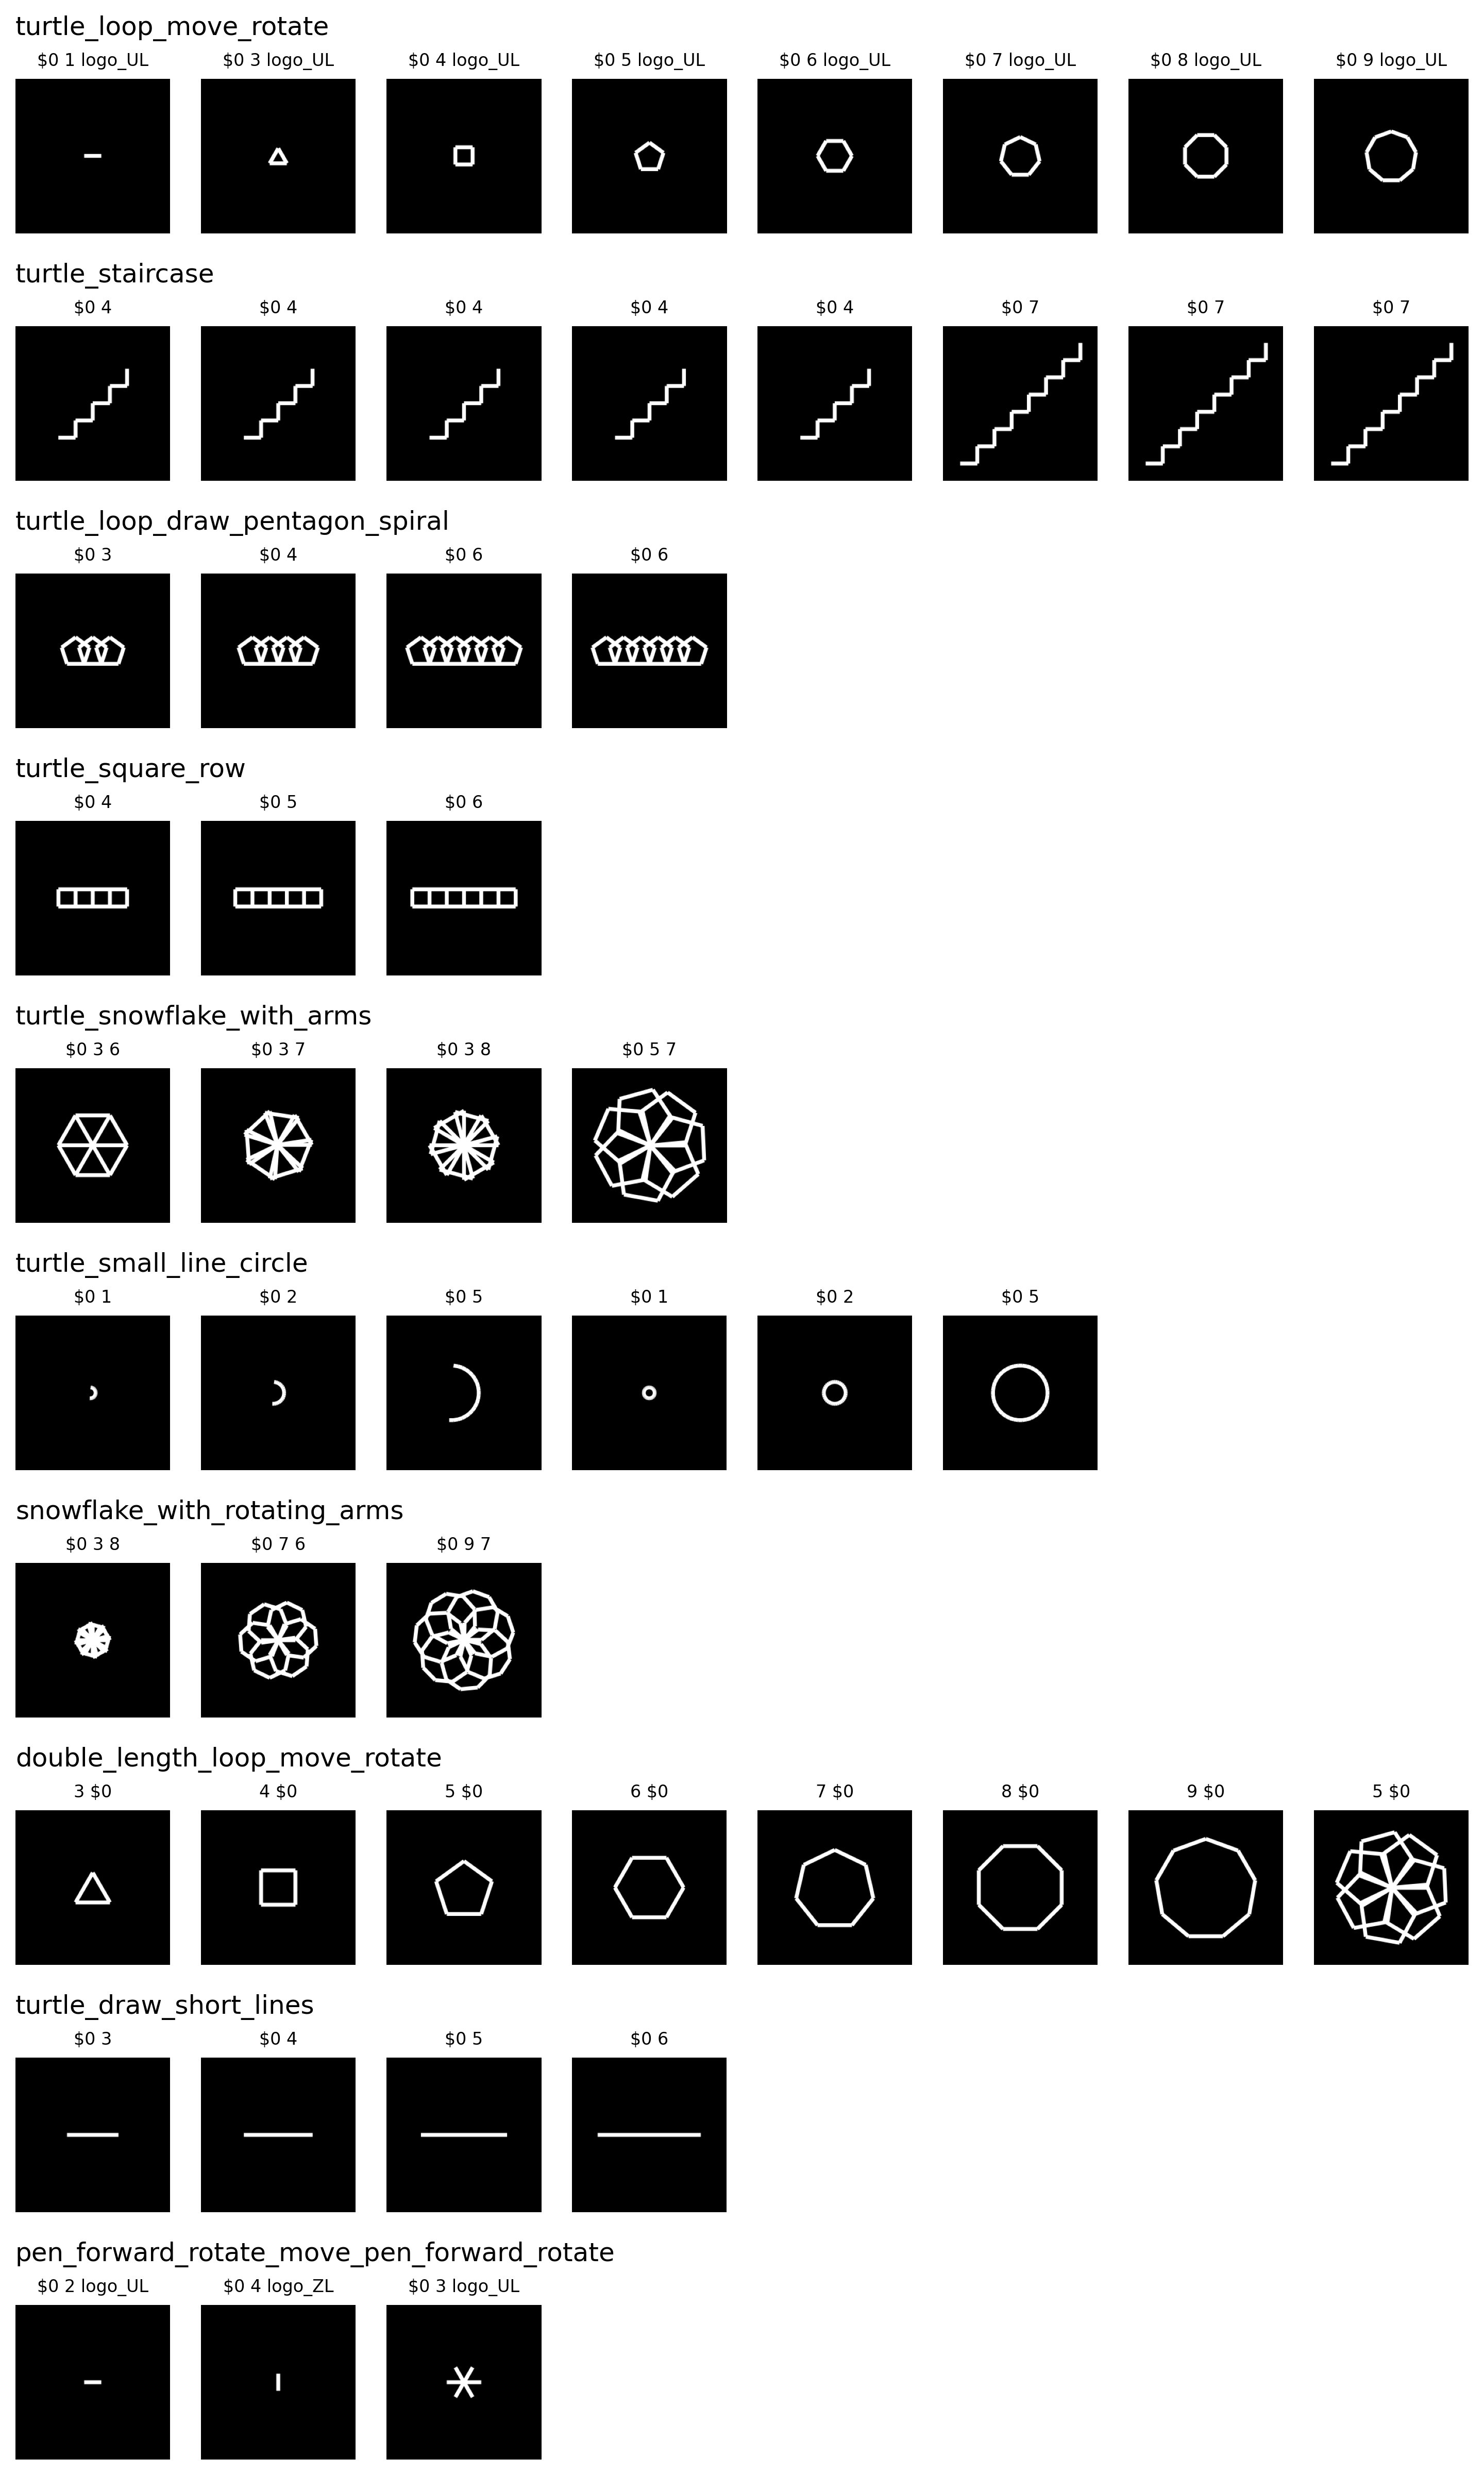

In [47]:
readable_names = list(fn_body_to_readable.values())

# Determine the maximum number of images in an abstraction
max_images = max(images.shape[0] for images in images_by_abstraction)

# Create a figure and an ImageGrid object with the desired dimensions
fig = plt.figure(figsize=(max_images*2, len(images_by_abstraction)*2), dpi=300)
grid = ImageGrid(fig, 111, nrows_ncols=(len(images_by_abstraction), max_images), axes_pad=(0.2, 0.6))

# Loop through each abstraction and each image, and plot it in the appropriate grid cell
for i, images in enumerate(images_by_abstraction):
    num_images = images.shape[0]
    
    for j in range(max_images):
        ax = grid[max_images*i+j]
        if j < num_images:
            ax.imshow(images[j], cmap='gray')
            ax.axis('off')
            ax.set_title(args_by_abstraction[i][j], fontsize=8)
        else:
            ax.axis('off')

    # Add a title to the row indicating the abstraction level
    grid[i*max_images].set_title(readable_names[i], fontsize=12, loc="left", y=1.20)

plt.savefig(os.path.join(FIGURES_DIR, "logo_examples.png"), dpi=300, bbox_inches="tight")
plt.show()


# Renders for figures

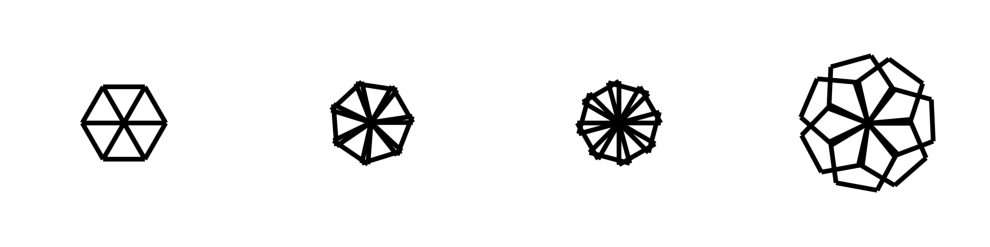

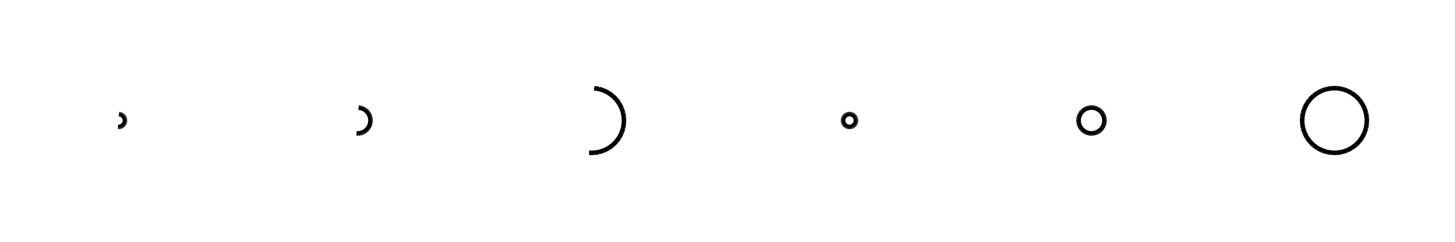

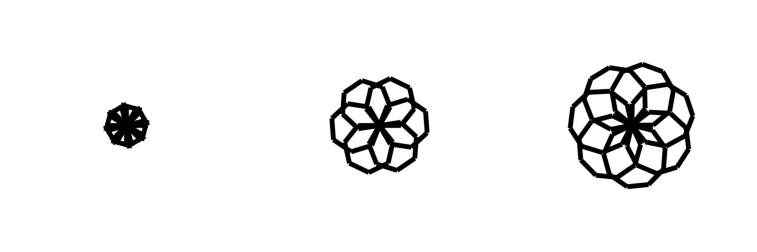

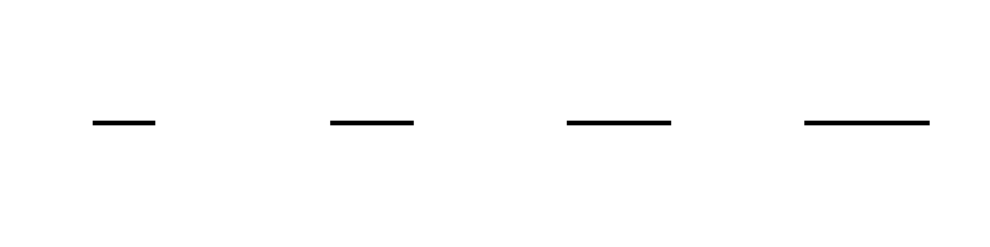

In [60]:

readable_names = list(fn_body_to_readable.values())

for abstraction_i in range(len(images_by_abstraction)):

    # Determine the maximum number of images in an abstraction
    images = images_by_abstraction[abstraction_i]
    max_images = len(images)

    # Create a figure and an ImageGrid object with the desired dimensions
    fig = plt.figure(figsize=(max_images, 1), dpi=300)
    grid = ImageGrid(fig, 111, nrows_ncols=(1, max_images), axes_pad=(0.2, 0.6))

    for j in range(len(images)):
        ax = grid[j]
        ax.imshow(images[j], cmap='gray_r')
        ax.axis('off')
        # ax.set_title(args_by_abstraction[i][j], fontsize=8)

    plt.savefig(os.path.join(FIGURES_DIR, f"logo_examples_{abstraction_i}.png"), dpi=300, bbox_inches="tight")
    plt.show()
